# CSE4224 Project 2
#### Grant Butler | gbutler2020@my.fit.edu

#### Data Retrieval/Cleaning:
Here, I will use the Spotify API to get the audio features of the tracks in my library, and create a cleaned pandas dataframe to be used with PCA and t-SNE after.

In [4]:
# connect to spotify api

from dotenv import dotenv_values
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
from spotipy.client import SpotifyException
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import json
import plotly.graph_objs as go

# use dotenv to import api creds
secrets = dotenv_values(".env")

# making authentication manager for spotipy to communicate with spotify
auth_manager = SpotifyClientCredentials(client_id=secrets["SPOTIPY_CLIENT_ID"],
                                        client_secret=secrets["SPOTIPY_CLIENT_SECRET"])

# auth_manager = SpotifyOAuth(client_id=secrets['SPOTIPY_CLIENT_ID'],
#                                                  client_secret=secrets['SPOTIPY_CLIENT_SECRET'],
#                                                  redirect_uri='http://127.0.0.1',
#                                                  scope='user-library-read')

sp = spotipy.Spotify(auth_manager=auth_manager)  # making spotipy object
sp.trace = False  # no debugging needed

In [2]:
# getting track ids from playlist

# grabbing the track ids and adding them to an array passed into them
def show_tracks(results, uriArray):
    for i, item in enumerate(results['items']):
        track = item['track']
        uriArray.append(track['id'])

# taking in the tracks from the playlist and grabbing the ids before returning them to a list
def get_playlist_track_ids(username, playlist_id):
    track_ids = []  # to store track ids
    # playlist = sp.user_playlist(username, playlist_id)  # get playlist
    playlist = sp.current_user_saved_tracks()
    tracks = playlist  # getting tracks from playlist

    # loop through the tracks and append them with helper function
    while tracks['next']:
        tracks = sp.next(tracks)
        show_tracks(tracks, track_ids)
    return track_ids


track_ids = get_playlist_track_ids(secrets['SPOTIFY_USERNAME'],
                                   secrets['PLAYLIST_ID'])

print(track_ids)

HTTP Error for GET to https://api.spotify.com/v1/me/tracks with Params: {'limit': 20, 'offset': 0, 'market': None} returned 403 due to Forbidden.


SpotifyException: http status: 403, code:-1 - https://api.spotify.com/v1/me/tracks?limit=20&offset=0:
 Forbidden., reason: None

In [ ]:


# helper function to split up the bigger list of track ids (spotify api limits to 100 tracks)
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# taking in a chunk at a time, ensuring they are strings, and then adding on the features and returning them
def get_audio_features(track_ids):
    audio_features = []
    for chunk in chunks(track_ids, 100):
        chunk = [str(track_id) for track_id in chunk]
        audio_features.extend(sp.audio_features(chunk))
    return audio_features

audio_features = get_audio_features(track_ids)
print(json.dumps(audio_features, indent=2))

In [ ]:


# ensuring there are no entries without data
cleaned_features = [item for item in audio_features if item is not None]

# making dataframe from the list of dicts
df = pd.DataFrame(cleaned_features)

# remove fields that have no bearing on analysis
fields_to_remove = ["analysis_url", "track_href", "type", "uri"]
df = df.drop(columns=fields_to_remove)

print(df)

#### PCA Dimensional Reduction:

Using PCA, I hope to reduce the number of dimensions that t-SNE needs to work with.

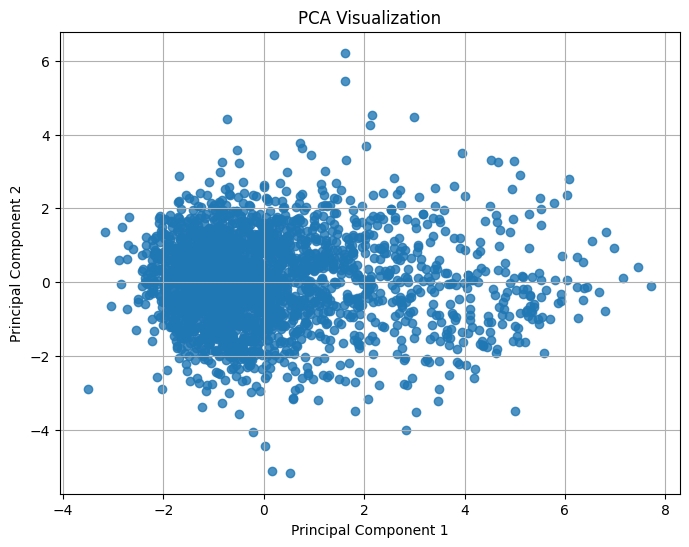

In [14]:
# remove ids for numeric data only
features = pd.read_json('./data/features.json')
# track_ids = pd.read_json('./data/track_ids.json')

non_numeric = ["analysis_url", "track_href", "type", "uri", "id"]
df_numeric = features.drop(columns=non_numeric)

# use standard scaler to centeralize and normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# apply PCA
pca = PCA(n_components=6) # only 2 dimensions for visualization
X_pca = pca.fit_transform(X_scaled)

# visualize PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.8)
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Visualize PCA in 3D
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], alpha=0.8)
# ax.set_title('PCA Visualization in 3D')
# ax.set_xlabel('Principal Component 1')
# ax.set_ylabel('Principal Component 2')
# ax.set_zlabel('Principal Component 3')
# plt.grid(True)
# plt.show()

In [15]:
# checking loadings of principal components
loadings = pca.components_

loadings_df = pd.DataFrame(loadings, columns=df_numeric.columns)

print(loadings_df)

   danceability    energy       key  loudness      mode  speechiness  \
0     -0.301962 -0.453390 -0.009907 -0.489233  0.049646    -0.142933   
1      0.479648 -0.257760  0.048704 -0.149900  0.047053     0.417144   
2     -0.058984 -0.020385  0.669797  0.009660 -0.688707     0.039942   
3     -0.251427  0.100660 -0.179466  0.081757  0.130495     0.366412   
4      0.106618 -0.280552 -0.187305 -0.083337 -0.055446     0.367043   
5      0.106179  0.040027 -0.085593  0.156411  0.028923    -0.315704   

   acousticness  instrumentalness  liveness   valence     tempo  duration_ms  \
0      0.378745          0.358715 -0.106439 -0.290033 -0.155605    -0.122367   
1      0.247029         -0.191396 -0.116804  0.398690 -0.121244    -0.458517   
2      0.086658         -0.101403  0.134618 -0.034599 -0.148046     0.064133   
3     -0.035099         -0.174832  0.619712 -0.190159 -0.329702    -0.126426   
4      0.155025         -0.311213 -0.038811 -0.287631 -0.192587     0.548766   
5     -0.099062

Principal Component 1: Explained Variance Ratio = 0.2376
Principal Component 2: Explained Variance Ratio = 0.1062
Principal Component 3: Explained Variance Ratio = 0.0930
Principal Component 4: Explained Variance Ratio = 0.0891
Principal Component 5: Explained Variance Ratio = 0.0820
Principal Component 6: Explained Variance Ratio = 0.0747


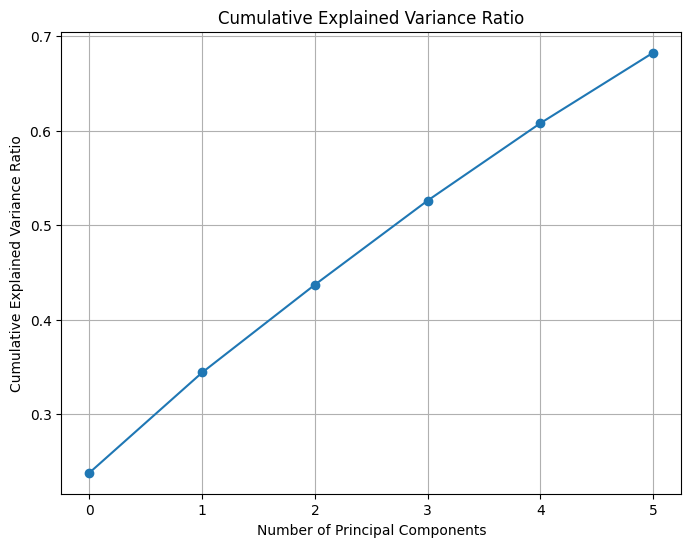

In [16]:
import numpy as np

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio for each component
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Principal Component {i + 1}: Explained Variance Ratio = {ratio:.4f}")

# Plot the cumulative explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='-')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [17]:


# sort the loadings to be the most impactful first

loadings_diff = np.abs(np.diff(loadings, axis=0))
loadings_diff_sum = loadings_diff.sum(axis=0)
loadings_diff_df = pd.DataFrame(
    loadings_diff_sum, index=df_numeric.columns, columns=['Sum of Loadings Diff'])

loadings_diff_sorted = loadings_diff_df.sort_values(by='Sum of Loadings Diff', ascending=False)

print(loadings_diff_sorted)

                  Sum of Loadings Diff
duration_ms                   2.101725
time_signature                2.027443
speechiness                   1.947128
danceability                  1.871170
mode                          1.827866
liveness                      1.789857
valence                       1.723198
key                           1.638518
energy                        1.255840
instrumentalness              0.988046
loudness                      0.975833
tempo                         0.880842
acousticness                  0.858055


#### Apply t-SNE on PCA Data

Using *t*-SNE on data from PCA.

In [ ]:
from sklearn.manifold import TSNE

# using 2 components for t-SNE for visualization after reducing with PCA
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.8)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

In [ ]:
# using k-means to group the clusters and color them based on that

from sklearn.cluster import KMeans

num_clusters = 28

# apply k-means to t-SNE results
kmeans = KMeans(n_clusters=num_clusters, random_state=523)
clusters = kmeans.fit_predict(X_tsne)

colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(clusters))))

plt.figure(figsize=(24, 18))
for cluster_id, color in zip(np.unique(clusters), colors):
    cluster_indices = np.where(clusters == cluster_id)[0]
    plt.scatter(X_tsne[cluster_indices, 0], X_tsne[cluster_indices,
                1], label=f'Cluster {cluster_id}', color=color, alpha=0.8)
plt.title('t-SNE Visualization (Clustered)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend() # legends for whether you see which cluster is which
plt.grid(True)
plt.show()

In [ ]:
# # exporting the track ids with cluster information 
# cluster_track_ids = {}
# clusters = clusters.astype(int)
# cluster_track_ids = [{'track_id': track_id, 'cluster_label': int(cluster_label)}
#                      for track_id, cluster_label in zip(track_ids, clusters)]

# sorted_tracks = sorted(cluster_track_ids, key=lambda x: x['cluster_label'])

# with open('clustered_track_ids.json', 'w') as f:
#     json.dump(sorted_tracks, f, indent=4)

In [ ]:
# from spotipy.oauth2 import SpotifyOAuth
# import time

# with open('clustered_track_ids.json', 'r') as f:
#     sorted_data = json.load(f)

# sp_2 = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=secrets['SPOTIPY_CLIENT_ID'],
#                                                  client_secret=secrets['SPOTIPY_CLIENT_SECRET'],
#                                                  redirect_uri='http://127.0.0.1',
#                                                  scope='playlist-modify-public'))

# batch_size = 50

# for cluster_label in range(num_clusters):
#     temp_tracks = [str(item['track_id']) for item in sorted_data if item['cluster_label']
#                    == cluster_label and item['track_id'] is not None]

#     playlist_name = f'tsne gr cluster {cluster_label}'
#     new_playlist = sp_2.user_playlist_create(
#         sp_2.me()['id'], playlist_name, public=True)
#     for i in range(0, len(temp_tracks), batch_size):
#         batch = temp_tracks[i:i+batch_size]
#         sp_2.playlist_add_items(new_playlist['id'], batch)
#         time.sleep(5)